# Data processing

In this notebook, the goal is to take the .nc files that we downloaded from the ERA5 dataset and process them into Pandas DataFrame that can be used elsewhere. The main steps are:

1. **Loading the data**: open the .nc files and save them.
2. **Filtering by time**: select only the data from the time period we are interested in.
3. **Filtering by region**: select only the data from the region we are interested in.
4. **Clustering**: run K-Means clustering on the data, so we can reduce the dimensionality of the problem.
5. **Taking zoomed data**: we also have another set of attributes focused solely on the Netherlands region.
6. **Include season functions**: we also include season functions, which are functions that are 1 when the data is in a certain season and 0 otherwise.
7. **Save the data**: save the data into a Pandas DataFrame.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap

import os

In [36]:
# Configurations cell. Change these and re-run the notebook to generate a new dataset file

K = 20
lag_time = 1
time_window_size = 8
netherland_coords = [52.5, 4.5]
center_coords = [0, 0]
should_normalize_clusterings = False
should_include_season_fns = True
date_start, date_end = "1979-01-07", "2021-12-31"

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
version_name = "v3"

# 1. Load data

In [3]:
attr_names = ["msl", "t2m", "sst", "r"]
target_name = "tp"

In [4]:
xarrays = {
    "msl": xr.load_dataset("../data/msl_r-global_t-weekly.nc"),
    "t2m": xr.load_dataset("../data/t2m_r-global_t-weekly.nc"),
    "sst": xr.load_dataset("../data/sst_r-global_t-weekly.nc"),
    "r": xr.load_dataset("../data/rh_r-global_t-weekly.nc"),
    "tp": xr.load_dataset("../data/tp_r-netherlands_t-weekly-tp.nc"),
}

In [5]:
xarrays["msl"]

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 2296)
Coordinates:
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 85.5 87.0 88.5 90.0
  * lon      (lon) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-08 ... 2022-12-26
Data variables:
    msl      (time, lat, lon) float32 1.004e+05 1.004e+05 ... 1.012e+05
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-07-18T19:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
resolution = (xarrays["msl"].lon.values.max() - xarrays["msl"].lon.values.min()) / (xarrays["msl"].lon.values.shape[0] - 1)
lats = np.arange(xarrays["msl"].lat.values.min(), xarrays["msl"].lat.values.max() + resolution, resolution)
lons = np.arange(xarrays["msl"].lon.values.min(), xarrays["msl"].lon.values.max() + resolution, resolution)

resolution, lats, lons

(1.5,
 array([-90. , -88.5, -87. , -85.5, -84. , -82.5, -81. , -79.5, -78. ,
        -76.5, -75. , -73.5, -72. , -70.5, -69. , -67.5, -66. , -64.5,
        -63. , -61.5, -60. , -58.5, -57. , -55.5, -54. , -52.5, -51. ,
        -49.5, -48. , -46.5, -45. , -43.5, -42. , -40.5, -39. , -37.5,
        -36. , -34.5, -33. , -31.5, -30. , -28.5, -27. , -25.5, -24. ,
        -22.5, -21. , -19.5, -18. , -16.5, -15. , -13.5, -12. , -10.5,
         -9. ,  -7.5,  -6. ,  -4.5,  -3. ,  -1.5,   0. ,   1.5,   3. ,
          4.5,   6. ,   7.5,   9. ,  10.5,  12. ,  13.5,  15. ,  16.5,
         18. ,  19.5,  21. ,  22.5,  24. ,  25.5,  27. ,  28.5,  30. ,
         31.5,  33. ,  34.5,  36. ,  37.5,  39. ,  40.5,  42. ,  43.5,
         45. ,  46.5,  48. ,  49.5,  51. ,  52.5,  54. ,  55.5,  57. ,
         58.5,  60. ,  61.5,  63. ,  64.5,  66. ,  67.5,  69. ,  70.5,
         72. ,  73.5,  75. ,  76.5,  78. ,  79.5,  81. ,  82.5,  84. ,
         85.5,  87. ,  88.5,  90. ]),
 array([-180. , -178.5, -177. , -

In [7]:
dims = (xarrays["msl"].msl.to_numpy().shape[1:])
n_days = dims[0] * dims[1]

dims, n_days

((121, 240), 29040)

# 2. Filter by time

Select only the data from the time period we are interested in.

In [8]:
for name in attr_names + [target_name]:
    xarrays[name] = xarrays[name].sel(time=slice(date_start, date_end))

T = len(xarrays["msl"].time)
print("The dataset has {} time steps".format(T))

The dataset has 2243 time steps


In [9]:
# displaying timestamps of each attribute
np.vstack([a.time.values for a in xarrays.values()]).T

array([['1979-01-08T00:00:00.000000000', '1979-01-08T00:00:00.000000000',
        '1979-01-08T00:00:00.000000000', '1979-01-08T00:00:00.000000000',
        '1979-01-07T00:00:00.000000000'],
       ['1979-01-15T00:00:00.000000000', '1979-01-15T00:00:00.000000000',
        '1979-01-15T00:00:00.000000000', '1979-01-15T00:00:00.000000000',
        '1979-01-14T00:00:00.000000000'],
       ['1979-01-22T00:00:00.000000000', '1979-01-22T00:00:00.000000000',
        '1979-01-22T00:00:00.000000000', '1979-01-22T00:00:00.000000000',
        '1979-01-21T00:00:00.000000000'],
       ...,
       ['2021-12-13T00:00:00.000000000', '2021-12-13T00:00:00.000000000',
        '2021-12-13T00:00:00.000000000', '2021-12-13T00:00:00.000000000',
        '2021-12-12T00:00:00.000000000'],
       ['2021-12-20T00:00:00.000000000', '2021-12-20T00:00:00.000000000',
        '2021-12-20T00:00:00.000000000', '2021-12-20T00:00:00.000000000',
        '2021-12-19T00:00:00.000000000'],
       ['2021-12-27T00:00:00.000000000

# 3. Filter by region

Here is where you'd filter the data by region. For now, we are using every data point available to us.

In [10]:
attr_values, attr_grid = {}, {}
for attr_name in attr_names:
    values = getattr(xarrays[attr_name], attr_name).values
    attr_values[attr_name] = np.reshape(values, (-1, n_days))
    attr_grid[attr_name] = np.reshape(values, (-1, *dims))

# In cells with terrain, the SST is NaN. We replace it with 0
attr_values["sst"][np.where(np.isnan(attr_values["sst"]) == True)] = 0

# 4. Clustering

The next step is running K-Means clustering on the data, so we can reduce the dimensionality of the problem. The idea is that instead of taking the data from each cell, we take the data from each of the $K$ clusters (i.e. it doesn't matter the temperature at (95.5, 4.5), but rather the temperature at the centroid of the cluster that (95.5, 4.5) belongs to).

The clustering can be done with or without previous normalization of the attributes (this is determined by the configuration cell up top). The normalization is done by subtracting the mean and dividing by the standard deviation of each attribute.

We can also take the mean value of each cluster, or the value of each cluster's centroid.

In [11]:
def preprocess_data_for_clustering(data):
    data_std = np.std(data, axis=0)
    data_std[np.where(data_std == 0)] = 1

    if should_normalize_clusterings:
        return (data - np.mean(data, axis=0)) / data_std
    else:
        return data

attr_values_norm = [preprocess_data_for_clustering(data) for data in attr_values.values()]
attr_values_norm

[array([[100523.5  , 100523.5  , 100523.5  , ..., 102648.11 , 102648.11 ,
         102648.11 ],
        [100548.35 , 100548.35 , 100548.35 , ..., 102181.32 , 102181.32 ,
         102181.32 ],
        [100122.64 , 100122.64 , 100122.64 , ..., 103675.414, 103675.414,
         103675.414],
        ...,
        [100301.96 , 100301.96 , 100301.96 , ..., 101186.18 , 101186.18 ,
         101186.18 ],
        [ 98746.39 ,  98746.39 ,  98746.39 , ..., 102929.17 , 102929.17 ,
         102929.17 ],
        [ 99246.52 ,  99246.52 ,  99246.52 , ..., 102810.99 , 102810.99 ,
         102810.99 ]], dtype=float32),
 array([[244.3605 , 244.3605 , 244.3605 , ..., 244.7271 , 244.7271 ,
         244.7271 ],
        [240.75774, 240.75774, 240.75774, ..., 243.92253, 243.92253,
         243.92253],
        [241.88878, 241.88878, 241.88878, ..., 242.22844, 242.22844,
         242.22844],
        ...,
        [248.43275, 248.43275, 248.43275, ..., 247.82214, 247.82214,
         247.82214],
        [252.00902, 2

In [12]:
clusterings = [KMeans(n_clusters=K, random_state=0).fit(attr_data.T) for attr_data in attr_values_norm]
clusterings

C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\

[KMeans(n_clusters=20, random_state=0),
 KMeans(n_clusters=20, random_state=0),
 KMeans(n_clusters=20, random_state=0),
 KMeans(n_clusters=20, random_state=0)]

In [13]:
# P lists (one for each attribute)
# Inside each list, K lists (one for each cluster)
# Inside each cluster, lists of indices of the cells in that cluster
indices_by_cluster = [[[idx for idx, label in enumerate(clustering.labels_) if label == k] for k in range(K)] for clustering in clusterings]
indices_by_cluster

[[[18672,
   18673,
   18674,
   18675,
   18676,
   18677,
   18678,
   18679,
   18680,
   18911,
   18912,
   18913,
   18914,
   18915,
   18916,
   18917,
   18918,
   18919,
   18920,
   18921,
   18922,
   18923,
   19149,
   19150,
   19151,
   19152,
   19153,
   19154,
   19155,
   19156,
   19157,
   19158,
   19159,
   19160,
   19161,
   19162,
   19163,
   19164,
   19165,
   19389,
   19390,
   19391,
   19392,
   19393,
   19394,
   19395,
   19396,
   19397,
   19398,
   19399,
   19400,
   19401,
   19402,
   19403,
   19404,
   19405,
   19594,
   19613,
   19623,
   19624,
   19630,
   19631,
   19632,
   19633,
   19634,
   19635,
   19636,
   19637,
   19638,
   19639,
   19640,
   19641,
   19642,
   19643,
   19644,
   19645,
   19646,
   19833,
   19840,
   19853,
   19870,
   19871,
   19872,
   19873,
   19874,
   19875,
   19876,
   19877,
   19878,
   19879,
   19880,
   19881,
   19882,
   19883,
   19884,
   19885,
   19886,
   19887,
   20072,
   20073,


In [14]:
get_closest = lambda target_cell_val : np.argmin([np.linalg.norm(cell_val - target_cell_val) for cell_val in attr_data.T])

centroids_all = []
for i, (clustering, attr_data) in enumerate(zip(clusterings, attr_values_norm)):
    centroids = [get_closest(clustering.cluster_centers_[k]) for k in range(K)]
    centroids = np.unravel_index(centroids, dims)
    centroids_all.append(centroids)

centroids_all = np.array(centroids_all)
centroids_all

array([[[ 87,  74,  24,  47,   3, 100,   1,  22,  67,  10,  14, 119,
          59,  10, 113, 108,  69, 103, 108,  55],
        [202, 131, 161,  74,  50,  13, 158,  46, 149,  30,  77, 202,
          67, 112,  69, 156, 147, 109,  13, 144]],

       [[ 60,  18,   2,  24, 118,  45,  12,  79,  87,  93,  42,  87,
           6,   1, 106,  84,  29,  77, 114,  96],
        [ 96, 162,  70, 163, 235, 182, 234, 177, 205, 235,  72, 125,
          66, 152, 205, 195, 209, 143,  91, 195]],

       [[  0,  86,  22,  51,  35,  98,  13,  76,  43,  25,  81,  92,
          41,  33,  96,  47,  87,  24, 110,  60],
        [  0, 103, 181,  97, 107, 235, 233,  84,  54, 233,  96, 114,
         126, 119,  27, 105,  71, 211, 157,  87]],

       [[  6,  55,  34,  98,  22,  31, 113,   1,  81,  43, 105,  38,
          51,  26, 120,  71,  67,  92,  87,  38],
        [ 35, 110, 146,  49, 209, 149,  39, 191, 189,  77, 194,  68,
          82, 166,   0,  55, 151,  86,  73, 181]]], dtype=int64)

In [15]:
centroids_all.shape

(4, 2, 20)

In [16]:
attr_cluster_centroids = {}
for name, centroids in zip(attr_names, centroids_all):
    attr_cluster_centroids[name] = attr_grid[name][:, centroids[0], centroids[1]]

In [17]:
attr_cluster_means = {}
for name, attr_idxs_by_cluster in zip(attr_names, indices_by_cluster):
    attr_cluster_means[name] = np.array([np.mean(attr_values[name][:, attr_idxs_by_cluster[k]], axis=1) for k in range(K)]).T

Plotting stuff so we can know where we're at:

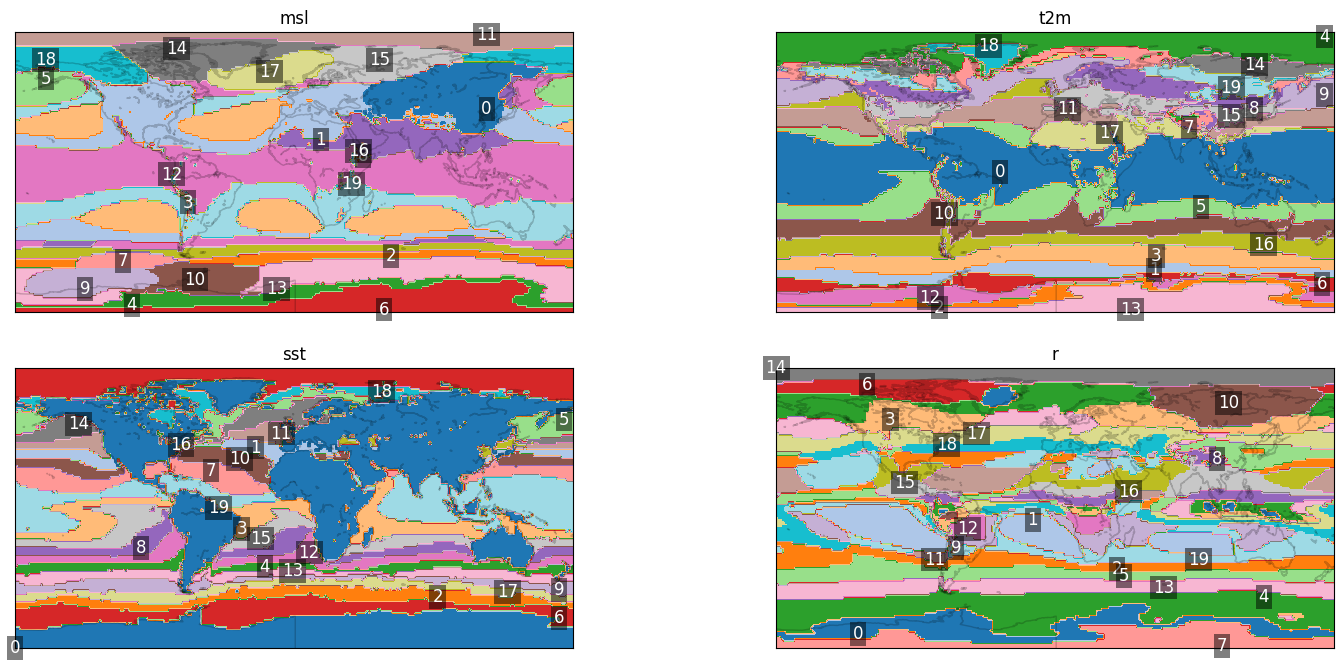

In [18]:
# coords = netherlands_coords
# coord_slice = (np.tile(coords, 2) + np.tile([24, 24], 2) * np.array([-1, -1, 1, 1])).reshape([2, 2])
coords = netherland_coords
coord_slice = np.array([[lats[0], lons[0]], [lats[-1], lons[-1]]])

fig, axs = plt.subplots(2, 2, figsize=(18, 8))

for i, (name, clustering, centroids) in enumerate(zip(attr_names, clusterings, centroids_all)):
    ax = axs[i // 2, i % 2]

    m = Basemap(
        ax = ax,
        resolution = 'l',
        llcrnrlat = coord_slice[0, 0], llcrnrlon = coord_slice[0, 1],
        urcrnrlat = coord_slice[1, 0], urcrnrlon = coord_slice[1, 1])

    # Draw coast
    coast = m.drawcoastlines(color='#00000033')

    # Draw clusterization
    x = np.reshape(clustering.labels_, dims)
    img = m.imshow(x, cmap='tab20')

    # Draw centroids. 'j'-th centroid has the same color as the 'j'-th cluster
    lats_c = [lats[idx] for idx in centroids[0]]
    lons_c = [lons[idx] for idx in centroids[1]]
    cx, cy = m(lons_c, lats_c)
    # m.scatter(cx, cy, marker='o', c=range(10), cmap='tab20', s=100, edgecolor='white')

    # On top of each of the j-th centroids, draw 'j'
    for j, (x, y) in enumerate(zip(cx, cy)):
        ax.text(x, y, str(j), fontsize=12, color="white", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2))

    ax.set_title(name)

plt.show()

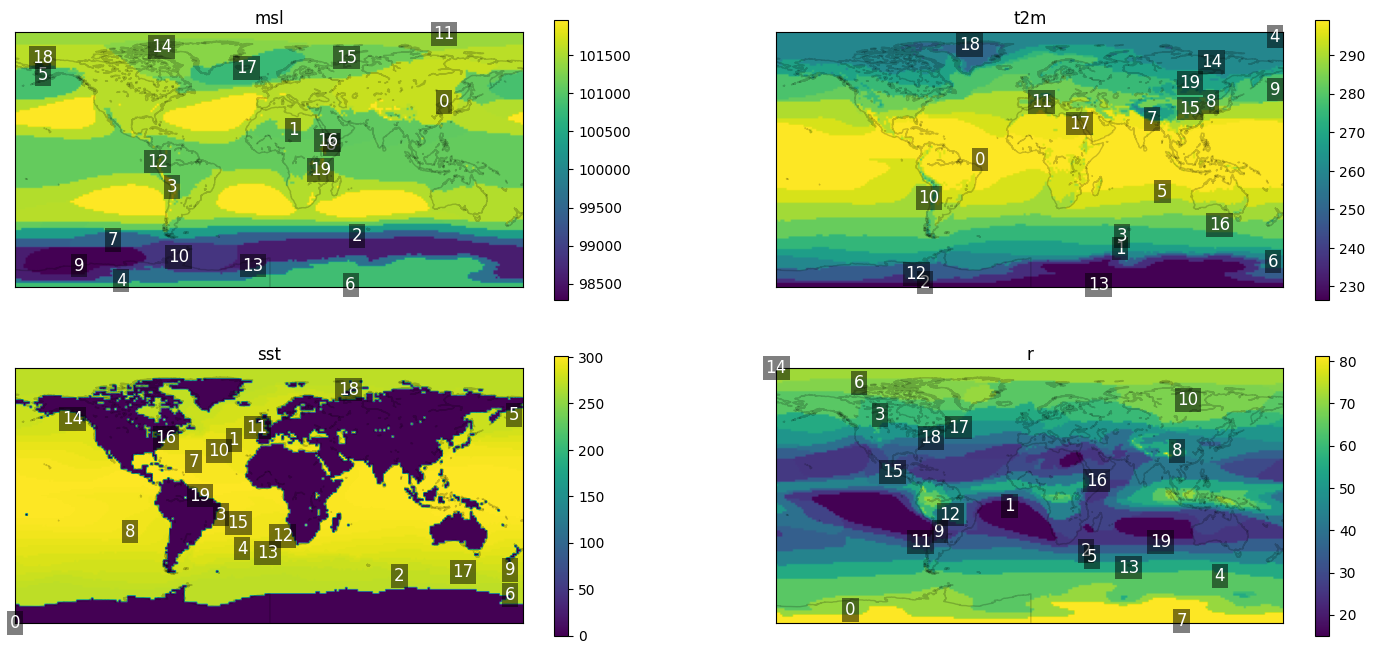

In [19]:
# coords = netherlands_coords
# coord_slice = (np.tile(coords, 2) + np.tile([24, 24], 2) * np.array([-1, -1, 1, 1])).reshape([2, 2])
coords = netherland_coords
coord_slice = np.array([[lats[0], lons[0]], [lats[-1], lons[-1]]])

fig, axs = plt.subplots(2, 2, figsize=(18, 8))

for i, (name, clustering, centroids) in enumerate(zip(attr_names, clusterings, centroids_all)):
    ax = axs[i // 2, i % 2]
    vals = attr_cluster_means[name]

    m = Basemap(
        ax = ax,
        resolution = 'l',
        llcrnrlat = coord_slice[0, 0], llcrnrlon = coord_slice[0, 1],
        urcrnrlat = coord_slice[1, 0], urcrnrlon = coord_slice[1, 1]
    )

    # Draw coast
    coast = m.drawcoastlines(color='#00000033')

    # Draw clusterization
    x = np.reshape(np.mean(vals, axis=0)[clustering.labels_], dims)
    img = m.imshow(x, cmap='viridis')

    # Draw centroids. 'j'-th centroid has the same color as the 'j'-th cluster
    lats_c = [lats[idx] for idx in centroids[0]]
    lons_c = [lons[idx] for idx in centroids[1]]
    cx, cy = m(lons_c, lats_c)
    # m.scatter(cx, cy, marker='o', c=range(10), cmap='tab20', s=100, edgecolor='white')

    # On top of each of the j-th centroids, draw 'j'
    for j, (x, y) in enumerate(zip(cx, cy)):
        ax.text(x, y, str(j), fontsize=12, color="white", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2))

    plt.colorbar(img, ax=ax, orientation="vertical")
    ax.set_title(name)

plt.show()

# 5. Taking zoomed data

We also have another set of attributes focused solely on the Netherlands region.

In [20]:
def get_zoomed_data(data, lat, lon):
    lat_idx = np.where(lats == lat)[0][0]
    lon_idx = np.where(lons == lon)[0][0]
    return data[:, lat_idx-1:lat_idx+2, lon_idx-1:lon_idx+2]

In [21]:
attr_values_zoomed = {}
for name in attr_names:
    attr_values_zoomed[name] = np.reshape(get_zoomed_data(attr_grid[name], *netherland_coords), (-1, 9))

Plotting the region that is selected by the zoomed data:

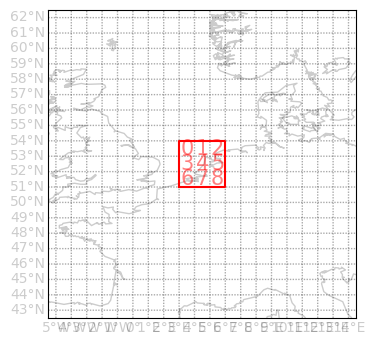

In [22]:
coords = netherland_coords
coord_slice = (np.tile(coords, 2) + np.tile([10, 10], 2) * np.array([-1, -1, 1, 1])).reshape([2, 2])

plt.figure(figsize=(4, 4))

m = Basemap(
    resolution = 'l',
    llcrnrlat = coord_slice[0, 0], llcrnrlon = coord_slice[0, 1],
    urcrnrlat = coord_slice[1, 0], urcrnrlon = coord_slice[1, 1]
)

m.drawparallels(np.arange(-90., 90., 1.), labels=[1, 0, 0, 0], fontsize=10, color='#00000055', alpha=0.2)
m.drawmeridians(np.arange(-180., 180., 1.), labels=[0, 0, 0, 1], fontsize=10, color='#00000055', alpha=0.2)
coast = m.drawcoastlines(color='#00000033')

# Highlight the 3x3 cells centered on the Netherlands
m.plot(
    [coords[1] - 1.5, coords[1] + 1.5, coords[1] + 1.5, coords[1] - 1.5, coords[1] - 1.5],
    [coords[0] - 1.5, coords[0] - 1.5, coords[0] + 1.5, coords[0] + 1.5, coords[0] - 1.5],
    latlon=True, color='red'
)

# Draw 0, 1, 2, 3, 4, 5, 6, 7, 8 in the cells
for i in range(3):
    for j in range(3):
        plt.text(
            coords[1] - 1.5 + j + 0.5,
            coords[0] + 0.5 - i + 0.5,
            str(i * 3 + j),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=15, color='red', alpha=0.5
        )

plt.xticks(rotation=45)
plt.show()

# 6. Include season functions

We also add season functions, which are functions that are 1 when the data is in a certain season and 0 otherwise. This may be useful if the model needs to learn different behaviors for different seasons (which is most probably the case).

In [23]:
days_in_year = 365
weeks_in_year = 52
interval = weeks_in_year

In [24]:
# Create a vector with the index of the start of each year (needs to take leap years into account, otherwise it would be just jumping 52 weeks ahead)
year_offsets = []
leap_year_offset = 0
for i in range(43):
    year_offsets.append(i * interval + leap_year_offset)
    leap_year_offset += ((i + 1) % 4 == 0)
year_offsets = np.array(year_offsets[:T//interval])
year_offsets

array([   0,   52,  104,  156,  209,  261,  313,  365,  418,  470,  522,
        574,  627,  679,  731,  783,  836,  888,  940,  992, 1045, 1097,
       1149, 1201, 1254, 1306, 1358, 1410, 1463, 1515, 1567, 1619, 1672,
       1724, 1776, 1828, 1881, 1933, 1985, 2037, 2090, 2142, 2194])

In [25]:
# season_duration = 90
# input_data_c3.time.to_numpy()[[73 + season_duration//2 + year_offsets,
#                                165 + season_duration//2 + year_offsets,
#                                257 + season_duration//2 + year_offsets,
#                                (348 + season_duration//2) % 365 + year_offsets]].T

In [26]:
season_duration = 12
xarrays["msl"].time.to_numpy()[np.concatenate((8 + season_duration//2 + year_offsets,
                               21 + season_duration//2 + year_offsets,
                               34 + season_duration//2 + year_offsets,
                               (47 + season_duration//2) % 53 + year_offsets))].T

array(['1979-04-16T00:00:00.000000000', '1980-04-14T00:00:00.000000000',
       '1981-04-13T00:00:00.000000000', '1982-04-12T00:00:00.000000000',
       '1983-04-18T00:00:00.000000000', '1984-04-16T00:00:00.000000000',
       '1985-04-15T00:00:00.000000000', '1986-04-14T00:00:00.000000000',
       '1987-04-20T00:00:00.000000000', '1988-04-18T00:00:00.000000000',
       '1989-04-17T00:00:00.000000000', '1990-04-16T00:00:00.000000000',
       '1991-04-22T00:00:00.000000000', '1992-04-20T00:00:00.000000000',
       '1993-04-19T00:00:00.000000000', '1994-04-18T00:00:00.000000000',
       '1995-04-24T00:00:00.000000000', '1996-04-22T00:00:00.000000000',
       '1997-04-21T00:00:00.000000000', '1998-04-20T00:00:00.000000000',
       '1999-04-26T00:00:00.000000000', '2000-04-24T00:00:00.000000000',
       '2001-04-23T00:00:00.000000000', '2002-04-22T00:00:00.000000000',
       '2003-04-28T00:00:00.000000000', '2004-04-26T00:00:00.000000000',
       '2005-04-25T00:00:00.000000000', '2006-04-24

In [27]:
N = attr_values["msl"].shape[0]
f_x = lambda n, m_i, sigma : np.exp(- 1/2 * ((np.arange(0, n) - m_i)**2) / sigma)
season_data = np.array([np.mean([f_x(N, season, 10) for season in (year_offsets + season_middle)], axis=0) * 1e3 for season_middle in [8, 21, 34, 47]]).T
season_data

array([[9.47958232e-01, 6.17075379e-09, 1.83785181e-24, 2.50441340e-47],
       [2.00682759e+00, 4.79338052e-08, 5.23838006e-23, 2.61924039e-45],
       [3.84416019e+00, 3.36911741e-07, 1.35099602e-21, 2.47865026e-43],
       ...,
       [1.02440090e-30, 6.23489272e-13, 1.73624607e-02, 2.21216145e+01],
       [2.17989811e-32, 4.86830811e-14, 4.97442826e-03, 2.32558140e+01],
       [4.19732881e-34, 3.43951873e-15, 1.28957208e-03, 2.21216145e+01]])

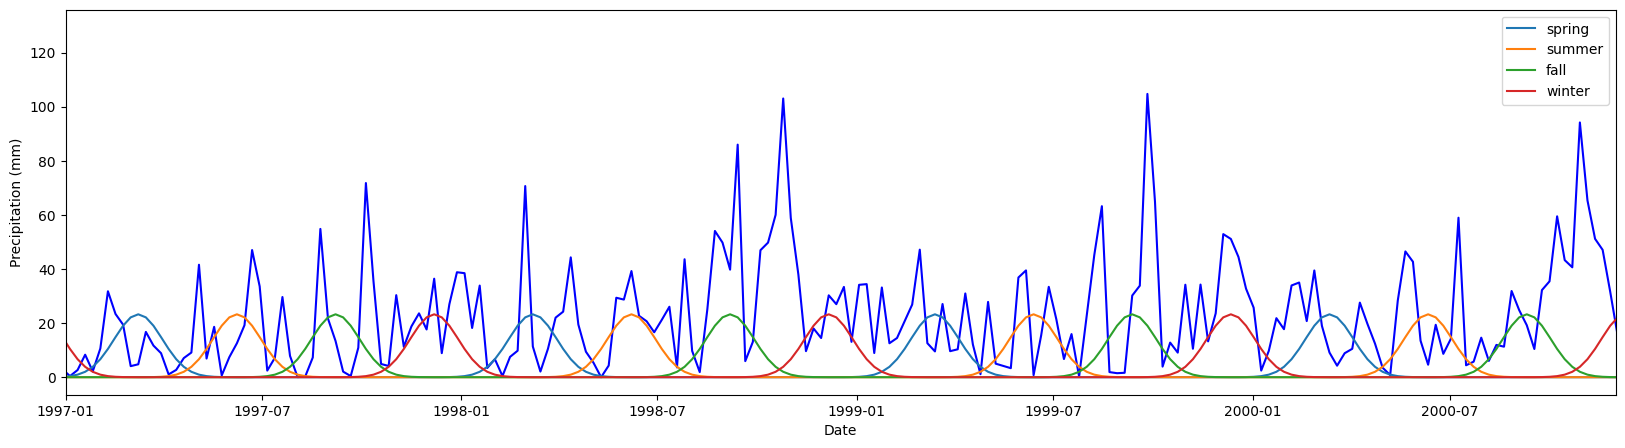

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(xarrays[target_name].time, getattr(xarrays[target_name], target_name).to_numpy() * 1000, color="blue")
for season, x_i in zip(["spring", "summer", "fall", "winter"], season_data.T):
    plt.plot(xarrays[target_name].time, x_i, label=season)

plt.xlim(datetime.datetime(1997, 1, 1), datetime.datetime(2000, 12, 1))
plt.legend()
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

# 7. Save the data

In [40]:
def get_attribute_cols(attr_id, attr_flag):
    if attr_flag == 0:
        return np.zeros((0, 0))
    elif attr_flag == 1:
        return attr_cluster_centroids[attr_id]
    elif attr_flag == 2:
        return attr_cluster_means[attr_id]
    elif attr_flag == 3:
        return attr_values_zoomed[attr_id]
    else:
        raise ValueError("Attribute flag must be 0, 1, 2 or 3")

In [41]:
columns = []
data = []

for name in attr_names:
    for attr_flag in range(1, 4):
        flag_str = ["cc", "cm", "zi"][attr_flag - 1]
        attr_values = get_attribute_cols(name, attr_flag)

        columns.append([f"{name}_{flag_str}_{i}" for i, _ in enumerate(attr_values[0])])
        data.append(attr_values)

columns = [i for k in columns for i in k]
data = np.concatenate(data, axis=1)

df = pd.DataFrame(data, columns=columns)
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_cm_19,r_zi_0,r_zi_1,r_zi_2,r_zi_3,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8
0,102774.554688,101606.375000,98541.695312,101836.296875,99910.757812,100295.000000,100460.023438,99184.375000,101447.875000,98987.921875,...,27.370834,78.531723,78.700729,71.836121,76.044487,68.434319,66.696838,59.167236,62.127750,68.537285
1,102459.890625,101584.625000,99628.335938,101911.492188,100081.976562,98412.046875,100312.023438,98978.257812,101578.242188,99226.921875,...,32.511936,60.850574,61.385559,57.981129,63.056141,66.899612,65.824783,71.189850,69.310516,62.125671
2,102349.242188,101803.773438,98930.179688,101894.992188,99196.648438,100259.835938,100020.007812,99459.796875,101498.125000,98302.250000,...,32.245949,58.976658,57.373756,59.284607,69.769661,67.228531,63.367638,71.111580,69.913963,71.185570
3,102926.703125,101689.390625,99140.148438,101886.312500,99155.921875,101464.039062,99953.578125,99241.078125,101454.734375,98632.953125,...,28.185429,65.124641,65.544304,65.857605,59.702633,60.181492,61.059868,61.021870,60.930157,58.795002
4,102328.960938,101663.460938,100456.828125,101808.453125,99623.492188,102716.390625,100536.351562,99358.257812,101338.953125,98710.226562,...,30.773876,63.826603,63.363041,60.454750,50.806911,44.702656,39.775372,31.059681,29.233988,27.226521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,102261.742188,101758.195312,99227.617188,101880.179688,98722.750000,101230.039062,99360.039062,98416.890625,101535.335938,97774.828125,...,29.627197,68.104599,68.707619,72.193878,69.368225,69.912476,72.905800,67.913277,71.166679,70.885010
2239,103018.757812,101737.757812,99095.070312,101949.289062,98030.351562,99875.265625,98778.375000,99664.710938,101689.148438,96022.039062,...,27.976473,69.620155,67.605598,61.475281,69.219414,68.518059,59.579769,68.117645,68.000572,65.350372
2240,102185.867188,101826.179688,99705.054688,102001.664062,99230.132812,101261.820312,100426.078125,99764.640625,101544.945312,97012.445312,...,27.970680,25.155516,27.614651,28.130751,26.920153,28.756506,29.183332,35.088261,34.982582,34.433987
2241,103066.648438,101909.765625,98688.578125,101981.421875,98387.976562,102201.554688,98897.507812,98813.398438,101552.773438,97600.015625,...,36.767754,47.275112,46.896759,48.736015,52.683247,46.674080,41.246246,45.447929,44.859493,41.570995


In [42]:
df["season_spring"] = season_data[:, 0]
df["season_summer"] = season_data[:, 1]
df["season_fall"] = season_data[:, 2]
df["season_winter"] = season_data[:, 3]
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_zi_3,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8,season_spring,season_summer,season_fall,season_winter
0,102774.554688,101606.375000,98541.695312,101836.296875,99910.757812,100295.000000,100460.023438,99184.375000,101447.875000,98987.921875,...,76.044487,68.434319,66.696838,59.167236,62.127750,68.537285,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47
1,102459.890625,101584.625000,99628.335938,101911.492188,100081.976562,98412.046875,100312.023438,98978.257812,101578.242188,99226.921875,...,63.056141,66.899612,65.824783,71.189850,69.310516,62.125671,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45
2,102349.242188,101803.773438,98930.179688,101894.992188,99196.648438,100259.835938,100020.007812,99459.796875,101498.125000,98302.250000,...,69.769661,67.228531,63.367638,71.111580,69.913963,71.185570,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43
3,102926.703125,101689.390625,99140.148438,101886.312500,99155.921875,101464.039062,99953.578125,99241.078125,101454.734375,98632.953125,...,59.702633,60.181492,61.059868,61.021870,60.930157,58.795002,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41
4,102328.960938,101663.460938,100456.828125,101808.453125,99623.492188,102716.390625,100536.351562,99358.257812,101338.953125,98710.226562,...,50.806911,44.702656,39.775372,31.059681,29.233988,27.226521,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,102261.742188,101758.195312,99227.617188,101880.179688,98722.750000,101230.039062,99360.039062,98416.890625,101535.335938,97774.828125,...,69.368225,69.912476,72.905800,67.913277,71.166679,70.885010,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01
2239,103018.757812,101737.757812,99095.070312,101949.289062,98030.351562,99875.265625,98778.375000,99664.710938,101689.148438,96022.039062,...,69.219414,68.518059,59.579769,68.117645,68.000572,65.350372,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01
2240,102185.867188,101826.179688,99705.054688,102001.664062,99230.132812,101261.820312,100426.078125,99764.640625,101544.945312,97012.445312,...,26.920153,28.756506,29.183332,35.088261,34.982582,34.433987,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01
2241,103066.648438,101909.765625,98688.578125,101981.421875,98387.976562,102201.554688,98897.507812,98813.398438,101552.773438,97600.015625,...,52.683247,46.674080,41.246246,45.447929,44.859493,41.570995,2.179898e-32,4.868308e-14,4.974428e-03,2.325581e+01


In [43]:
target_col = f"target_{target_name}"
# multiplying by 1000 to get mm instead of m
df[target_col] = getattr(xarrays[target_name], target_name).to_numpy() * 1000
df[target_col] = df[target_col].shift(- lag_time)
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8,season_spring,season_summer,season_fall,season_winter,target_tp
0,102774.554688,101606.375000,98541.695312,101836.296875,99910.757812,100295.000000,100460.023438,99184.375000,101447.875000,98987.921875,...,68.434319,66.696838,59.167236,62.127750,68.537285,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102459.890625,101584.625000,99628.335938,101911.492188,100081.976562,98412.046875,100312.023438,98978.257812,101578.242188,99226.921875,...,66.899612,65.824783,71.189850,69.310516,62.125671,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102349.242188,101803.773438,98930.179688,101894.992188,99196.648438,100259.835938,100020.007812,99459.796875,101498.125000,98302.250000,...,67.228531,63.367638,71.111580,69.913963,71.185570,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490191
3,102926.703125,101689.390625,99140.148438,101886.312500,99155.921875,101464.039062,99953.578125,99241.078125,101454.734375,98632.953125,...,60.181492,61.059868,61.021870,60.930157,58.795002,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102328.960938,101663.460938,100456.828125,101808.453125,99623.492188,102716.390625,100536.351562,99358.257812,101338.953125,98710.226562,...,44.702656,39.775372,31.059681,29.233988,27.226521,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,102261.742188,101758.195312,99227.617188,101880.179688,98722.750000,101230.039062,99360.039062,98416.890625,101535.335938,97774.828125,...,69.912476,72.905800,67.913277,71.166679,70.885010,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,103018.757812,101737.757812,99095.070312,101949.289062,98030.351562,99875.265625,98778.375000,99664.710938,101689.148438,96022.039062,...,68.518059,59.579769,68.117645,68.000572,65.350372,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102185.867188,101826.179688,99705.054688,102001.664062,99230.132812,101261.820312,100426.078125,99764.640625,101544.945312,97012.445312,...,28.756506,29.183332,35.088261,34.982582,34.433987,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257
2241,103066.648438,101909.765625,98688.578125,101981.421875,98387.976562,102201.554688,98897.507812,98813.398438,101552.773438,97600.015625,...,46.674080,41.246246,45.447929,44.859493,41.570995,2.179898e-32,4.868308e-14,4.974428e-03,2.325581e+01,29.003620


In [44]:
df.dropna(inplace=True)
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8,season_spring,season_summer,season_fall,season_winter,target_tp
0,102774.554688,101606.375000,98541.695312,101836.296875,99910.757812,100295.000000,100460.023438,99184.375000,101447.875000,98987.921875,...,68.434319,66.696838,59.167236,62.127750,68.537285,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102459.890625,101584.625000,99628.335938,101911.492188,100081.976562,98412.046875,100312.023438,98978.257812,101578.242188,99226.921875,...,66.899612,65.824783,71.189850,69.310516,62.125671,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102349.242188,101803.773438,98930.179688,101894.992188,99196.648438,100259.835938,100020.007812,99459.796875,101498.125000,98302.250000,...,67.228531,63.367638,71.111580,69.913963,71.185570,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490191
3,102926.703125,101689.390625,99140.148438,101886.312500,99155.921875,101464.039062,99953.578125,99241.078125,101454.734375,98632.953125,...,60.181492,61.059868,61.021870,60.930157,58.795002,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102328.960938,101663.460938,100456.828125,101808.453125,99623.492188,102716.390625,100536.351562,99358.257812,101338.953125,98710.226562,...,44.702656,39.775372,31.059681,29.233988,27.226521,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102507.273438,101810.750000,99068.062500,101762.171875,98799.304688,101092.679688,99126.296875,98299.335938,101412.921875,97048.562500,...,61.932987,60.554268,60.000252,60.375908,59.757931,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,102261.742188,101758.195312,99227.617188,101880.179688,98722.750000,101230.039062,99360.039062,98416.890625,101535.335938,97774.828125,...,69.912476,72.905800,67.913277,71.166679,70.885010,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,103018.757812,101737.757812,99095.070312,101949.289062,98030.351562,99875.265625,98778.375000,99664.710938,101689.148438,96022.039062,...,68.518059,59.579769,68.117645,68.000572,65.350372,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102185.867188,101826.179688,99705.054688,102001.664062,99230.132812,101261.820312,100426.078125,99764.640625,101544.945312,97012.445312,...,28.756506,29.183332,35.088261,34.982582,34.433987,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


In [47]:
filepath = f"../data/dataframe_lag-{lag_time}_K-{K}_{'cnorm' if should_normalize_clusterings else 'no-cnorm'}.csv"
df.to_csv(filepath, index=False)
print(f"Saved dataframe to {filepath}")

Saved dataframe to ../data/dataframe_lag-1_K-20_no-cnorm.csv
